In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<br>
<br>
<br>
<br>

# **Treinamento do Modelo (Regressão Logística)**

Neste notebook vamos treinar o modelo usando a técnica da Regressão Logística. Além de ser uma técnica que resulta em bons resultados, também é uma técnica facilmente explicável. Depois iremos verificar suas métricas e comparar com o modelo desafiante que utiliza outro algoritmo de machine learning.

<br>

## **Pacotes e Bibliotecas**

In [ ]:
# Instalação dos Pacotes.
!pip install colorama > /dev/null

In [ ]:
# Importando as bibliotecas Pandas e Numpy.
import pandas as pd
import numpy as np

# Importando a biblioteca Matplotlib para plotarmos gráficos que ajudarão no entendimento dos dados.
import matplotlib.pyplot as plt

# Importando as constantes definidas na biblioteca colorama que permitem alterar as cores e estilos de texto impresso no terminal.
from colorama import Fore, Style

# Importando a pickle para serialização.
import pickle

# Importando o pacote Statsmodels para o treinamento do nosso modelo com a Regressão Logística.
import statsmodels.api as sm

# Importando as bibliotecas para avaliação dos modelos.
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, auc, roc_auc_score

<br>
<br>
<br>
<br>

## **Funções**

In [ ]:
# Função para checar quantidade de linhas e colunas dos conjuntos de treino e teste.
def info_dataframe(treino, teste):
    '''
    Esta função exibe informações sobre a quantidade de linhas e colunas dos conjuntos de treino e teste.

    Parâmetros:
    - treino: DataFrame do conjunto de treino.
    - teste: DataFrame do conjunto de teste.

    Retorna:
    Um print com as informações.
    '''

    # Criando uma borda destacada para o título do conjunto de treino.
    print(Fore.BLUE + '=' * 45)
    print('CONJUNTO DE TREINO'.center(45))
    print('')
    print('Quantidade de linhas:', treino.shape[0])
    print('Quantidade de colunas:', treino.shape[1])
    print('=' * 45 + Style.RESET_ALL)
    print('')

    # Criando uma borda destacada para o título do conjunto de teste.
    print(Fore.GREEN + '=' * 45)
    print('CONJUNTO DE TESTE'.center(45))
    print('')
    print('Quantidade de linhas:', teste.shape[0])
    print('Quantidade de colunas:', teste.shape[1])
    print('=' * 45 + Style.RESET_ALL)



# =================================================================================================================================================== #



# Função para o treinamento do modelo e criação do scorecard.
def logistic_regression_with_scorecard(data, target_var, features):
    '''
    Esta função ajusta um modelo de regressão logística e cria um scorecard.

    Parâmetros:
    - data: DataFrame contendo os dados.
    - target_var: Nome da variável alvo.
    - features: Lista de nomes das variáveis explicativas.

    Retorna:
    Um objeto de modelo de regressão logística e um scorecard com coeficientes, valores P e estatísticas de Wald.
    '''

    # Adicionando uma constante ao dataset (intercepto).
    data = sm.add_constant(data)

    # Ajustando o modelo de regressão logística.
    model = sm.Logit(data[target_var], data[features + ['const']]).fit()

    # Coletando p-valores e estatísticas de Wald.
    summary = model.summary2().tables[1]
    summary['Wald'] = summary['z']**2
    scorecard = summary[['Coef.', 'P>|z|', 'Wald']]
    scorecard.columns = ['Beta Coefficient', 'P-Value', 'Wald Statistic']
    scorecard = scorecard.sort_values(by='Wald Statistic', ascending=False)

    return model, scorecard



# =================================================================================================================================================== #



# Função para cálculo das métricas de avaliação do modelo.
def calculate_metrics_01(model_name, model, X_train, y_train, X_test, y_test):
    '''
    Esta função calcula métricas de avaliação para um modelo de classificação binária.

    Parâmetros:
    - model_name: Nome do modelo.
    - model: Modelo treinado.
    - X_train: Features do conjunto de treino.
    - y_train: Variável alvo do conjunto de treino.
    - X_test: Features do conjunto de teste.
    - y_test: Variável alvo do conjunto de teste.

    Retorna:
    Um DataFrame com as métricas calculadas para os conjuntos de treino e teste.
    '''

    # Fazendo predições para treino e teste.
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Obtendo probabilidades para cálculo de métricas AUC-ROC.
    y_train_prob = model.predict(X_train)
    y_test_prob = model.predict(X_test)

    # Convertendo probabilidades para previsões binárias.
    y_train_pred_binary = (y_train_prob > 0.5).astype(int)
    y_test_pred_binary = (y_test_prob > 0.5).astype(int)

    # Calculando as métricas para o conjunto de treino.
    accuracy_train = accuracy_score(y_train, y_train_pred_binary)
    precision_train = precision_score(y_train, y_train_pred_binary)
    recall_train = recall_score(y_train, y_train_pred_binary)
    auc_roc_train = roc_auc_score(y_train, y_train_prob)

    # Calculando as métricas para o conjunto de teste.
    accuracy_test = accuracy_score(y_test, y_test_pred_binary)
    precision_test = precision_score(y_test, y_test_pred_binary)
    recall_test = recall_score(y_test, y_test_pred_binary)
    auc_roc_test = roc_auc_score(y_test, y_test_prob)

    # Calculando GINI e KS para o conjunto de treino.
    gini_train = 2 * auc_roc_train - 1
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': y_train_prob})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))

    # Calculando GINI e KS para o conjunto de teste.
    gini_test = 2 * auc_roc_test - 1
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': y_test_prob})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))

    # Criando o DataFrame com as métricas calculadas.
    metrics_df = pd.DataFrame({
        'Algoritmo': [model_name, model_name],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precision': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_train, gini_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })

    return metrics_df



# =================================================================================================================================================== #



# Função para o cálculo das métricas e plotagem do gráfico.
def calculate_metrics_02(train_df, test_df, score_column, score_0, target_column, bins=10):
    '''
    Esta função calcula métricas de avaliação e plota a taxa de evento por décil.

    Parâmetros:
    - treino_df: DataFrame do conjunto de treinamento.
    - teste_df: DataFrame do conjunto de teste.
    - coluna_score: Nome da coluna contendo os scores do modelo.
    - coluna_alvo: Nome da coluna contendo a variável alvo.
    - bins: Número de bins para dividir os dados (padrão é 10).

    Retorna:
    Um DataFrame com as métricas calculadas, e tabelas de taxa de evento por décil para os conjuntos de treinamento e teste.
    '''

    def compute_metrics(df, score_column, score_0, target_column):
        df_sorted = df.sort_values(by=score_column, ascending=False)

        # Calcular KS.
        df_sorted['cum_good'] = (1 - df_sorted[target_column]).cumsum() / (1 - df_sorted[target_column]).sum()
        df_sorted['cum_bad'] = df_sorted[target_column].cumsum() / df_sorted[target_column].sum()
        df_sorted['ks'] = np.abs(df_sorted['cum_good'] - df_sorted['cum_bad'])
        ks_statistic = df_sorted['ks'].max()

        # Calcular AUC.
        auc_value = roc_auc_score(df_sorted[target_column], df_sorted[score_column])

        # Calcular Gini.
        gini = 2 * auc_value - 1

        # Dividir o score em 10 faixas.
        df_sorted['decile'] = pd.qcut(df_sorted[score_0], bins, labels=False)

        # Criar tabela detalhada.
        table = df_sorted.groupby('decile').agg(
            min_score=pd.NamedAgg(column=score_0, aggfunc='min'),
            max_score=pd.NamedAgg(column=score_0, aggfunc='max'),
            event_rate=pd.NamedAgg(column=target_column, aggfunc='mean'),
            volume=pd.NamedAgg(column=target_column, aggfunc='size')
        ).reset_index()

        return ks_statistic, auc_value, gini, table

    ks_train, auc_train, gini_train, table_train = compute_metrics(train_df, score_column, score_0, target_column)
    ks_test, auc_test, gini_test, table_test = compute_metrics(test_df, score_column, score_0, target_column)

    # Plotando o gráfico de barras para Event Rate por Decil.
    barWidth = 0.3
    r1 = np.arange(len(table_train))
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, table_train['event_rate'], color='lightblue', width=barWidth, label='Train')
    plt.bar(r2, table_test['event_rate'], color='royalblue', width=barWidth, label='Test')

    plt.xlabel('Decile')
    plt.ylabel('Event Rate')
    plt.title('Event Rate by Decile')
    plt.xticks([r + barWidth for r in range(len(table_train))], table_train['decile'])
    plt.grid(axis='y', linestyle='-', alpha=0.3)
    plt.grid(axis='x', linestyle='-', alpha=0.3)
    plt.gca().set_axisbelow(True)
    plt.legend()
    plt.show()

    # Criando DataFrame para as métricas.
    metrics_df = pd.DataFrame({
        'Métricas': ['AUC', 'Gini', 'KS'],
        'Valor do Treino': [auc_train, gini_train, ks_train],
        'Valor do Teste': [auc_test, gini_test, ks_test]
    })

    return metrics_df, table_train, table_test



# =================================================================================================================================================== #



# Função para criação dos gráficos com as faixas de score e apetite de risco da base de treino.
def carteira_treino_rl(model, name_model, risk, X_train, y_train, prob_train):
  '''
  Esta função:
  - Faz as predições de probabilidade de evento e não-evento da base passada como parâmetro.
  - Separa os scores em 10 faixas.
  - Calcula a volumetria e a taxa de evento de cada faixa.
  - Gera uma linha horizontal que representa o apetite de risco assumido.
  - Analisa cada faixa e aplica cores diferentes nas barras de acordo com a taxa de evento da faixa e o apetite de risco assumido.
  - Calcula o percentual do público aprovado e não aprovado, de acordo com o apetitie de risco.

  Parâmetros:
  - model: Modelo que fará as predições.
  - name_model: Nome do modelo. Ex: 'Random Forest'.
  - risk: Risco, em decimais, possível de ser assumido (geralmente igual a inadimplência da carteira).
  - X_train: Base usada no treinamento do modelo.
  - y_train: Target usada no treinamento do modelo.
  - prob_train: Taxa de probabilidade da base de treino.

  Retorna:
  Faixas de limites superiores e inferiores de cada faixa de score. Esta faixa poderá ser passada como parâmetro na função 'carteira_teste' para que os limites das faixas sejam mantidos.
  '''

  # Configura o plot.
  fig, ax = plt.subplots(figsize=(12, 6))


  # Função para preencher as barras com cores diferentes.
  def fill_bars(ax, values, color_above, color_below, threshold=None):
    for val, bar in zip(values, ax.patches):
      if threshold is not None:
        if val >= threshold:
          bar.set_color(color_above)
        else:
          bar.set_color(color_below)
      else:
        bar.set_color(color_above if val >= risk else color_below)


  # Função para adicionar a linha horizontal de risco no eixo secundário.
  def add_risk_line(ax, risk_value, color='black'):

    # Adiciona a linha horizontal que representa o apetite de risco assumido.
    ax.axhline(y=risk_value, color=color, linestyle='--')

    # Adicionar texto acima da linha.
    texto_acima_linha = f'Risco: {100*risk_value:.1f}%'
    ax.text(0.5, risk_value+ 0.0025, texto_acima_linha)


  # Função para calcular as faixas (bins) e plotar o gráfico de barras dos dados de treino.
  def plot_bar_chart(ax, probabilidades, y_real, title, color_default, color_above, color_below, risk_value=None):
    df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_real})
    df = df.sort_values(by='Probabilidades', ascending=False)
    df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False, duplicates='drop')

    # Volumetria das faixas.
    df_vol = df.groupby('Deciles')['Deciles'].count().values

    # Extraindo o limite superior de score das faixas.
    faixas=[]
    for i in range(0,10):
      if i != 9:
        faixas.append(round(1000*df.loc[df['Deciles']==i ,'Probabilidades'].max()  , 0))
      else:
        faixas.append( 1000 )

    # Criando uma lista com os rótulos de cada bin.
    rotulos=[]
    for i in range(0, len(faixas)):
      if i == 0:
        rotulos.append(f'000 - {faixas[i]:.0f}')
      else:
        rotulos.append(f'{faixas[i-1]:.0f} - {faixas[i]:.0f}')

    # Agrupando os deciles e cálculando a média da propabilidade de evento em cada um.
    decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

    # Criação do eixo secundário.
    ax2 = ax.twinx()

    # Plota as linhas para a taxa de evento em cada bin no eixo secundário.
    ax2.plot(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='magenta', marker='o', label='Taxa de Evento')
    ax2.set_ylabel('Taxa de Evento')

    # Adiciona rótulos para a linha de taxa de evento.
    for i, (x, y) in enumerate(zip(decile_analysis['Deciles'], decile_analysis['Resposta Real'])):
      ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(10, 10), textcoords='offset points', ha='center', va='center', color='magenta')

    # Desligando o grid do gráfico secondário.
    ax2.grid(False)

    # Plota as barras de volumetria com cores diferentes se a taxa de evento for superior ao risk_value.
    for i, color in enumerate(['mistyrose', 'lightgreen'] * 5):
      ax.bar(i, df_vol[i], color=color if decile_analysis.loc[i, 'Resposta Real'] >= risk_value else color_default)

    # Configurações do gráfico.
    ax.set_title(title, pad=10)
    ax.set_xlabel('Faixas de Score')
    ax.set_ylabel('Volumetria da faixa')
    ax.set_xticks(range(len(rotulos)))
    ax.set_ylim(0, 1.2 * np.max(df_vol)) #Valor maximo do eixo y igual a 20% do maior valor de volumetria.
    ax.grid(False)

    # Configuração dos rótulos do eixo X para o gráfico.
    ax.set_xticklabels(rotulos, rotation=0)

    # Adicionando linha horizontal que representa o risco no eixo secundário.
    add_risk_line(ax2, risk_value)
    fill_bars(ax, decile_analysis['Resposta Real'], color_above, color_below, risk_value)

    # Lendo os deciles que estão abaixo da linha de risco.
    faixas_aprovadas = decile_analysis.loc[decile_analysis['Resposta Real']<=risk_value , 'Deciles']
    faixas_reprovadas = decile_analysis.loc[decile_analysis['Resposta Real']>risk_value , 'Deciles']

    # Convertendo em lista as faixas aprovadas / reprovadas.
    faixas_aprovadas = faixas_aprovadas.to_list()
    faixas_reprovadas = faixas_reprovadas.to_list()

    # Calculando a quantidade de pessoas aprovadas / reprovadas.
    qtd_aprovadas = df.loc[df['Deciles'].isin(faixas_aprovadas) ,  'Deciles'].count()
    qtd_reprovadas = df.loc[df['Deciles'].isin(faixas_reprovadas), 'Deciles'].count()

    # Calculando o percentual de pessoas aprovadas / reprovadas.
    perc_aprovadas = 100*round(qtd_aprovadas / df.shape[0]   , 2 )
    perc_reprovadas = 100*round(qtd_reprovadas / df.shape[0] , 2 )

    return perc_aprovadas , perc_reprovadas , color_above, color_below , faixas , df


  # -------------------------------------------------------------
  # Chamando a função de plot para dados de treino.
  # -------------------------------------------------------------

  # Previsão das probabilidades no conjunto de treino.
  # Probabilidade de NÃO-EVENTO (para inverter o gráfico).
  probabilidades_train = prob_train

  # Adiciona um pequeno ruído às probabilidades.
  noise_train = np.random.uniform(0, 0.0001, size=probabilidades_train.shape)
  probabilidades_train += noise_train

  # Plota o gráfico de barras para o conjunto de treino.
  perc_apr , perc_rep , color_above, color_below , faixas , df= plot_bar_chart(ax, probabilidades_train, y_train, 'Faixas de score, volumetrias e taxa de evento - base de treino ' + name_model,
                    'steelblue' , 'mistyrose', 'lightgreen', risk)

  # Criar entradas para a legenda com base nas cores.
  legend_labels = [f'Aprovados:   {perc_apr}% da base', f'Reprovados: {perc_rep}% da base']
  legend_colors = [color_below, color_above]

  # Adicionar manualmente entradas para cada cor na legenda.
  for label, color in zip(legend_labels, legend_colors):
    ax.bar(0, 0, color=color, label=label, linewidth=0)

  # Inserir legenda
  ax.legend( loc='upper left', bbox_to_anchor=(1.1, 1))

  plt.show()

  return faixas



# Função para criação dos gráficos com as faixas de score e apetite de risco da base de teste.
def carteira_teste_rl(faixas, model, name_model, risk, X_test, y_test , prob_test):
  '''
  Esta função:
  - Faz as predições de probabilidade de evento e não-evento da base passada como parâmetro.
  - Separa os scores em 10 faixas.
  - Calcula a volumetria e a taxa de evento de cada faixa.
  - Gera uma linha horizontal que representa o apetite de risco assumido.
  - Analisa cada faixa e aplica cores diferentes nas barras de acordo com a taxa de evento da faixa e o apetite de risco assumido.
  - Calcula o percentual do público aprovado e não aprovado, de acordo com o apetitie de risco.

  Parâmetros:
  - model: Modelo que fará as predições.
  - name_model: Nome do modelo. Ex: 'Random Forest'.
  - risk: Risco, em decimais, possível de ser assumido (geralmente igual a inadimplência da carteira).
  - X_test: Base usada no teste do modelo.
  - y_test: Target usada no teste do modelo.
  - prob_test: Taxa de probabilidade da base de teste.

  Retorna:
  Faixas de limites superiores e inferiores de cada faixa de score. Esta faixa poderá ser passada como parâmetro na função 'carteira_teste' para que os limites das faixas sejam mantidos.
  '''

  # Configura o plot.
  fig, ax = plt.subplots(figsize=(12, 6))

  # Função para preencher as barras com cores diferentes.
  def fill_bars(ax, values, color_above, color_below, threshold=None):
    for val, bar in zip(values, ax.patches):
      if threshold is not None:
        if val >= threshold:
          bar.set_color(color_above)
        else:
          bar.set_color(color_below)
      else:
        bar.set_color(color_above if val >= risk else color_below)


  # Função para adicionar a linha horizontal de risco no eixo secundário.
  def add_risk_line(ax, risk_value, color='black'):

    # Adiciona a linha horizontal que representa o risco.
    ax.axhline(y=risk_value, color=color, linestyle='--')

    # Adicionar texto acima da linha
    texto_acima_linha = f'Risco: {100*risk_value:.1f}%'
    ax.text(0.5, risk_value+ 0.0025, texto_acima_linha)


  # Função para aplicar as faixas (bins) e plotar o gráfico de barras dos dados de teste.
  def apply_deciles_plot_bar_chart(faixas, ax, probabilidades, y_real, title, color_default, color_above, color_below, risk_value=None):
    df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_real})
    df = df.sort_values(by='Probabilidades', ascending=False)

    # Ajustando os valores dos limites superiores e inferiores das faixas que anteriormente tinham sido multiplicados por mil.
    faixas = np.array(faixas)
    faixas=np.divide(faixas, 1000)
    faixas = faixas.tolist()

    # Adcionando o valor 0 no primeiro indice da lista de faixas.
    faixas.insert(0, 0)

    # Aplica as faixas fornecidas
    df['Deciles'] = pd.cut(df['Probabilidades'], bins=faixas, labels=False, include_lowest=True)

    # Volumetria das faixas
    df_vol = df.groupby('Deciles')['Deciles'].count().values


    # Removendo novamente o valor Zero (que está no ídice Zero) para a lista ter a mesma configuração do código anterior antes da extração dos rótulos.
    faixas.pop(0)

    # Criando uma lista com os rótulos de cada bin, multiplicando por mil.
    rotulos=[]
    for i in range(0, len(faixas)):
      if i == 0:
        rotulos.append(f'000 - {1000*faixas[i]:.0f}')
      else:
        rotulos.append(f'{1000*faixas[i-1]:.0f} - {1000*faixas[i]:.0f}')


    # Calculo da média de probabilidade de taxa de evento em cada bin.
    decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

    # Criação do eixo secundário.
    ax2 = ax.twinx()

    # Plota as linhas para a taxa de evento em cada bin no eixo secundário.
    ax2.plot(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='magenta', marker='o', label='Taxa de Evento')
    ax2.set_ylabel('Taxa de Evento')

    # Adiciona rótulos para a linha de taxa de evento.
    for i, (x, y) in enumerate(zip(decile_analysis['Deciles'], decile_analysis['Resposta Real'])):
      ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(10, 10), textcoords='offset points', ha='center', va='center', color='magenta')

    # Desligando o grid do gráfico secundário.
    ax2.grid(False)


    # Plota as barras de volumetria com cores diferentes se a taxa de evento for superior ao risk_value.
    for i, color in enumerate(['mistyrose', 'lightgreen'] * 5):
      ax.bar(i, df_vol[i], color=color if decile_analysis.loc[i, 'Resposta Real'] >= risk_value else color_default)

    # Configurações do gráfico.
    ax.set_title(title, pad=10)
    ax.set_xlabel('Faixas de Score')
    ax.set_ylabel('Volumetria da faixa')
    ax.set_xticks(range(len(rotulos)))
    ax.set_ylim(0, 1.2 * np.max(df_vol))  # Valor maximo do eixo y igual a 20% do maior valor de volumetria.
    ax.grid(False)


    # Configuração dos rótulos do eixo X para o gráfico.
    ax.set_xticklabels(rotulos, rotation=0)

    # Adicionando a linha horizontal que representa o risco no eixo secundário.
    add_risk_line(ax2, risk_value)
    fill_bars(ax, decile_analysis['Resposta Real'], color_above, color_below, risk_value)

    # Lendo os deciles que estão abaixo da linha de risco
    faixas_aprovadas = decile_analysis.loc[decile_analysis['Resposta Real']<=risk_value , 'Deciles']
    faixas_reprovadas = decile_analysis.loc[decile_analysis['Resposta Real']>risk_value , 'Deciles']

    # Convertendo em lista as faixas aprovadas / reprovadas.
    faixas_aprovadas = faixas_aprovadas.to_list()
    faixas_reprovadas = faixas_reprovadas.to_list()

    # Calculando a quantidade de pessoas aprovadas / reprovadas.
    qtd_aprovadas = df.loc[df['Deciles'].isin(faixas_aprovadas) ,  'Deciles'].count()
    qtd_reprovadas = df.loc[df['Deciles'].isin(faixas_reprovadas), 'Deciles'].count()

    # Calculando o percentual de pessoas aprovadas / reprovadas.
    perc_aprovadas = 100*round(qtd_aprovadas / df.shape[0]   , 1 )
    perc_reprovadas = 100*round(qtd_reprovadas / df.shape[0] , 1 )

    return perc_aprovadas , perc_reprovadas , color_above, color_below


  # -----------------------------------------------------------------------
  # Chamando a função de plot para dados de teste com os bins fixados.
  # -----------------------------------------------------------------------

  # Previsão das probabilidades no conjunto de teste.
  # Probabilidade de NÃO-EVENTO (para inverter o gráfico).
  probabilidades_test = prob_test

  # Adiciona um pequeno ruído às probabilidades.
  noise_test = np.random.uniform(0, 0.0001, size=probabilidades_test.shape)
  probabilidades_test += noise_test

  # Plota o gráfico de barras para o conjunto de teste.
  perc_apr , perc_rep , color_above, color_below = apply_deciles_plot_bar_chart (faixas, ax, probabilidades_test, y_test, 'Faixas de score, volumetrias e taxa de evento - base de teste ' + name_model,
                  'steelblue' , 'mistyrose', 'lightgreen', risk)

  # Criar entradas para a legenda com base nas cores.
  legend_labels = [f'Aprovados:   {perc_apr}% da base', f'Reprovados: {perc_rep}% da base']
  legend_colors = [color_below, color_above]

  # Adicionar manualmente entradas para cada cor na legenda.
  for label, color in zip(legend_labels, legend_colors):
    ax.bar(0, 0, color=color, label=label, linewidth=0)

  # Inserir legenda.
  ax.legend( loc='upper left', bbox_to_anchor=(1.1, 1))

  plt.show()

  return faixas

<br>
<br>
<br>
<br>

## **Diretórios**

In [ ]:
# Salvando o caminho do diretório principal.
dir = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech'

# Salvando o caminho do diretório dos arquivos pickle.
dir_pkl = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech/modelo_regressao_logistica/artefatos'

# Salvando o caminho do diretório das ABTs.
dir_abt = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech/modelo_regressao_logistica/abt'

<br>
<br>
<br>
<br>

## **Leitura das ABTs**

In [ ]:
# Lendo as bases de dados.
abt_train_01 = pd.read_csv(dir_abt + '/abt_train_01.csv')
abt_test_01 = pd.read_csv(dir_abt + '/abt_test_01.csv')

info_dataframe(abt_train_01, abt_test_01)

              CONJUNTO DE TREINO             

Quantidade de linhas: 172205
Quantidade de colunas: 57

              CONJUNTO DE TESTE              

Quantidade de linhas: 43052
Quantidade de colunas: 57


In [ ]:
# Definindo a opção para não truncar colunas.
pd.set_option('display.max_columns', None)

abt_train_01.head(10)

,NAME_CONTRACT_TYPE_Revolving loans,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_VERIFICAR,WALLSMATERIAL_MODE_Wooden,TFB_NAME_INCOME_TYPE_Unemployed,TFB_NAME_INCOME_TYPE_Working,TFB_NAME_HOUSING_TYPE_Office apartment,TFB_NAME_HOUSING_TYPE_Rented apartment,TFB_NAME_EDUCATION_TYPE_Incomplete higher,TFB_NAME_EDUCATION_TYPE_Lower secondary,TFB_NAME_TYPE_SUITE_Other_B,TFB_NAME_TYPE_SUITE_Unaccompanied,TFB_NAME_TYPE_SUITE_VERIFICAR,TFB_NAME_FAMILY_STATUS_Married,TFB_NAME_FAMILY_STATUS_Separated,TFB_NAME_FAMILY_STATUS_Widow,TFT_EXT_SOURCE_2_1,TFT_EXT_SOURCE_2_2,TFT_EXT_SOURCE_2_3,TFT_EXT_SOURCE_2_4,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_4,TFT_EXT_SOURCE_1_1,TFT_EXT_SOURCE_1_2,TFT_EXT_SOURCE_1_4,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_2,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_3,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_4,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_1,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_2,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_3,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_4,TFT_EXT_SOURCE_3_1,TFT_EXT_SOURCE_3_2,TFT_EXT_SOURCE_3_4,TFT_ORGANIZATION_TYPE_1,TFT_ORGANIZATION_TYPE_2,TFT_ORGANIZATION_TYPE_3,TFT_ORGANIZATION_TYPE_4,TFB_TFT_OCCUPATION_TYPE_3,TFB_TFT_OCCUPATION_TYPE_4,TFT_DAYS_BIRTH_1,TFT_DAYS_BIRTH_2,TFT_DAYS_BIRTH_3,TFT_DAYS_BIRTH_4,TFB_TFT_AMT_ANNUITY_2,TFB_TFT_AMT_ANNUITY_3,TFB_TFT_AMT_ANNUITY_4,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_1,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_3,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_4,TARGET,SK_ID_CURR
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,281575
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,253241
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,257591
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,440634
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,101232
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,378713
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,253842
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,223682
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,421310
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
abt_test_01.head(10)

,TARGET,SK_ID_CURR,NAME_CONTRACT_TYPE_Revolving loans,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_VERIFICAR,WALLSMATERIAL_MODE_Wooden,TFB_NAME_INCOME_TYPE_Unemployed,TFB_NAME_INCOME_TYPE_Working,TFB_NAME_HOUSING_TYPE_Office apartment,TFB_NAME_HOUSING_TYPE_Rented apartment,TFB_NAME_EDUCATION_TYPE_Incomplete higher,TFB_NAME_EDUCATION_TYPE_Lower secondary,TFB_NAME_TYPE_SUITE_Other_B,TFB_NAME_TYPE_SUITE_Unaccompanied,TFB_NAME_TYPE_SUITE_VERIFICAR,TFB_NAME_FAMILY_STATUS_Married,TFB_NAME_FAMILY_STATUS_Separated,TFB_NAME_FAMILY_STATUS_Widow,TFT_EXT_SOURCE_2_1,TFT_EXT_SOURCE_2_2,TFT_EXT_SOURCE_2_3,TFT_EXT_SOURCE_2_4,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_4,TFT_EXT_SOURCE_1_1,TFT_EXT_SOURCE_1_2,TFT_EXT_SOURCE_1_4,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_2,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_3,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_4,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_1,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_2,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_3,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_4,TFT_EXT_SOURCE_3_1,TFT_EXT_SOURCE_3_2,TFT_EXT_SOURCE_3_4,TFT_ORGANIZATION_TYPE_1,TFT_ORGANIZATION_TYPE_2,TFT_ORGANIZATION_TYPE_3,TFT_ORGANIZATION_TYPE_4,TFB_TFT_OCCUPATION_TYPE_3,TFB_TFT_OCCUPATION_TYPE_4,TFT_DAYS_BIRTH_1,TFT_DAYS_BIRTH_2,TFT_DAYS_BIRTH_3,TFT_DAYS_BIRTH_4,TFB_TFT_AMT_ANNUITY_2,TFB_TFT_AMT_ANNUITY_3,TFB_TFT_AMT_ANNUITY_4,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_1,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_3,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_4
0,0,243431,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0,127962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,244667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,220032,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,123746,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0,169967,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0,120237,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0,445579,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0,125013,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
9,1,246301,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1

In [ ]:
# Isolando o ID.
id_train = abt_train_01['SK_ID_CURR']
id_test = abt_test_01['SK_ID_CURR']

abt_train_01.drop(columns=['SK_ID_CURR'], inplace=True)
abt_test_01.drop(columns=['SK_ID_CURR'], inplace=True)

In [ ]:
abt_train_01.head()

,NAME_CONTRACT_TYPE_Revolving loans,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_VERIFICAR,WALLSMATERIAL_MODE_Wooden,TFB_NAME_INCOME_TYPE_Unemployed,TFB_NAME_INCOME_TYPE_Working,TFB_NAME_HOUSING_TYPE_Office apartment,TFB_NAME_HOUSING_TYPE_Rented apartment,TFB_NAME_EDUCATION_TYPE_Incomplete higher,TFB_NAME_EDUCATION_TYPE_Lower secondary,TFB_NAME_TYPE_SUITE_Other_B,TFB_NAME_TYPE_SUITE_Unaccompanied,TFB_NAME_TYPE_SUITE_VERIFICAR,TFB_NAME_FAMILY_STATUS_Married,TFB_NAME_FAMILY_STATUS_Separated,TFB_NAME_FAMILY_STATUS_Widow,TFT_EXT_SOURCE_2_1,TFT_EXT_SOURCE_2_2,TFT_EXT_SOURCE_2_3,TFT_EXT_SOURCE_2_4,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_2,TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_4,TFT_EXT_SOURCE_1_1,TFT_EXT_SOURCE_1_2,TFT_EXT_SOURCE_1_4,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_2,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_3,TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_4,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_1,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_2,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_3,TFT_VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP_4,TFT_EXT_SOURCE_3_1,TFT_EXT_SOURCE_3_2,TFT_EXT_SOURCE_3_4,TFT_ORGANIZATION_TYPE_1,TFT_ORGANIZATION_TYPE_2,TFT_ORGANIZATION_TYPE_3,TFT_ORGANIZATION_TYPE_4,TFB_TFT_OCCUPATION_TYPE_3,TFB_TFT_OCCUPATION_TYPE_4,TFT_DAYS_BIRTH_1,TFT_DAYS_BIRTH_2,TFT_DAYS_BIRTH_3,TFT_DAYS_BIRTH_4,TFB_TFT_AMT_ANNUITY_2,TFB_TFT_AMT_ANNUITY_3,TFB_TFT_AMT_ANNUITY_4,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_1,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_3,TFB_TFT_GOODS_CREDIT_RATIO_APP_TRAIN_4,TARGET
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


<br>
<br>
<br>
<br>

## **Treinamento do modelo**

In [ ]:
# Criando uma lista com todas as variáveis exceto a variável Target.
X = abt_train_01.drop(columns=['TARGET'])

lista_features_rl = list(X.columns)
lista_features_rl

['NAME_CONTRACT_TYPE_Revolving loans',
 'WALLSMATERIAL_MODE_Mixed',
 'WALLSMATERIAL_MODE_Monolithic',
 'WALLSMATERIAL_MODE_Others',
 'WALLSMATERIAL_MODE_Panel',
 'WALLSMATERIAL_MODE_Stone, brick',
 'WALLSMATERIAL_MODE_VERIFICAR',
 'WALLSMATERIAL_MODE_Wooden',
 'TFB_NAME_INCOME_TYPE_Unemployed',
 'TFB_NAME_INCOME_TYPE_Working',
 'TFB_NAME_HOUSING_TYPE_Office apartment',
 'TFB_NAME_HOUSING_TYPE_Rented apartment',
 'TFB_NAME_EDUCATION_TYPE_Incomplete higher',
 'TFB_NAME_EDUCATION_TYPE_Lower secondary',
 'TFB_NAME_TYPE_SUITE_Other_B',
 'TFB_NAME_TYPE_SUITE_Unaccompanied',
 'TFB_NAME_TYPE_SUITE_VERIFICAR',
 'TFB_NAME_FAMILY_STATUS_Married',
 'TFB_NAME_FAMILY_STATUS_Separated',
 'TFB_NAME_FAMILY_STATUS_Widow',
 'TFT_EXT_SOURCE_2_1',
 'TFT_EXT_SOURCE_2_2',
 'TFT_EXT_SOURCE_2_3',
 'TFT_EXT_SOURCE_2_4',
 'TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_2',
 'TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_4',
 'TFT_EXT_SOURCE_1_1',
 'TFT_EXT_SOURCE_1_2',
 'TFT_EXT_

In [ ]:
# Chamando a função de treinamento do modelo.
model, scorecard = logistic_regression_with_scorecard(abt_train_01, 'TARGET', lista_features_rl)
scorecard

Optimization terminated successfully.
         Current function value: 0.249887
         Iterations 8


,Beta Coefficient,P-Value,Wald Statistic
TFT_EXT_SOURCE_3_4,-0.635098,1.947468e-172,783.638138
TFT_EXT_SOURCE_2_4,-2.069161,6.058638e-95,427.374302
TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_3,0.550763,9.217056e-95,426.537113
TFT_EXT_SOURCE_3_1,0.836757,4.758169e-88,395.697994
TFT_EXT_SOURCE_3_2,0.424270,1.523923e-64,287.767689
TFT_EXT_SOURCE_2_3,-1.658170,9.133235e-63,279.609814
TFT_EXT_SOURCE_1_4,-0.508727,2.167278e-56,250.360193
TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_4,-0.332753,1.559272e-55,246.429230
TFT_EXT_SOURCE_2_2,-1.198604,2.032279e-33,145.109675
TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_2,0.269053,7.109000e-29,124.336861


In [ ]:
# Filtrar apenas as variáveis com P-Valor menor que 0.05.
scorecard_filtrado = scorecard[scorecard['P-Value'] < 0.05]
scorecard_filtrado

,Beta Coefficient,P-Value,Wald Statistic
TFT_EXT_SOURCE_3_4,-0.635098,1.947468e-172,783.638138
TFT_EXT_SOURCE_2_4,-2.069161,6.058638e-95,427.374302
TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_3,0.550763,9.217056e-95,426.537113
TFT_EXT_SOURCE_3_1,0.836757,4.758169e-88,395.697994
TFT_EXT_SOURCE_3_2,0.424270,1.523923e-64,287.767689
TFT_EXT_SOURCE_2_3,-1.658170,9.133235e-63,279.609814
TFT_EXT_SOURCE_1_4,-0.508727,2.167278e-56,250.360193
TFB_TFT_VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP_4,-0.332753,1.559272e-55,246.429230
TFT_EXT_SOURCE_2_2,-1.198604,2.032279e-33,145.109675
TFB_TFT_NEW_PAYMENT_RATE_APP_TRAIN_2,0.269053,7.109000e-29,124.336861


In [ ]:
# Salvando o modelo treinado em um arquivo .pkl (artefato).
with open(dir_pkl + '/model_rl.pkl', 'wb') as file:
  pickle.dump(model, file)

<br>
<br>
<br>
<br>

## **Métricas do modelo treinado**

In [ ]:
# Adicionando uma coluna constante com valor 1.0 ao conjunto de dados.
abt_train_01['const'] = 1.0
abt_test_01['const'] = 1.0

# Removendo a coluna 'TARGET' do conjunto de dados.
X_train = abt_train_01.drop(['TARGET'], axis=1)
y_train = abt_train_01['TARGET']

X_test = abt_test_01.drop(['TARGET'], axis=1)
y_test = abt_test_01['TARGET']

In [ ]:
# Chamando a função de métricas.
df_metrics = calculate_metrics_01('Regressão Logística', model, X_train, y_train, X_test, y_test)
df_metrics

,Algoritmo,Conjunto,Acuracia,Precision,Recall,AUC_ROC,GINI,KS
0,Regressão Logística,Treino,0.919253,0.484561,0.014685,0.745760,0.49152,0.364442
1,Regressão Logística,Teste,0.918099,0.472727,0.014773,0.743605,0.48721,0.370396


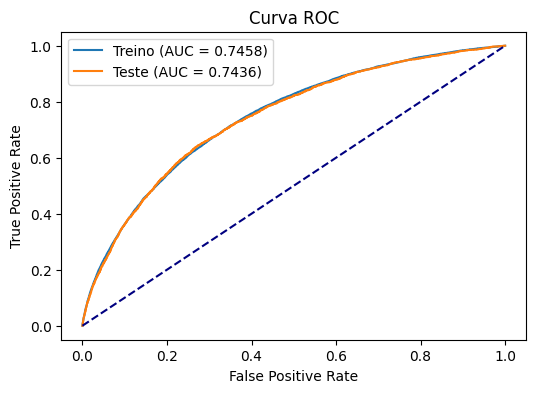

In [ ]:
# Curva ROC para Treino e Teste.
plt.subplots(figsize=(6,4))
for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
    fpr, tpr, _ = roc_curve(y, model.predict(X))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
# Prevendo a probabilidade de evento.
X_train['Score_1'] = model.predict(X_train).round(4)
X_test['Score_1'] = model.predict(X_test).round(4)

# Calculando a probabilidade de não evento.
X_train['Score_0'] = 1 - X_train['Score_1']
X_test['Score_0'] = 1 - X_test['Score_1']

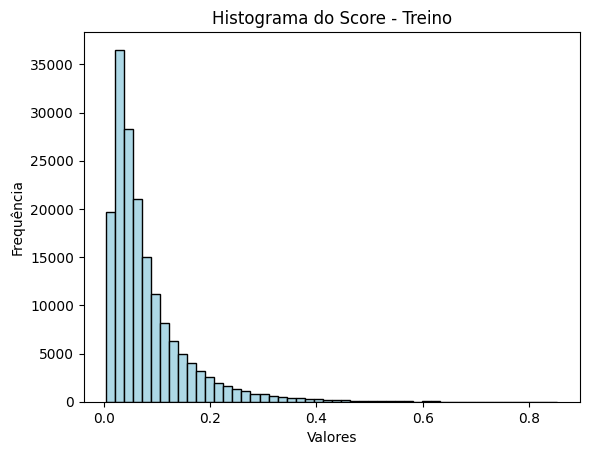

In [ ]:
# Plotando o histograma de treino.
plt.hist(X_train.Score_1, color='lightblue', bins=50, edgecolor='black')
plt.title('Histograma do Score - Treino')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

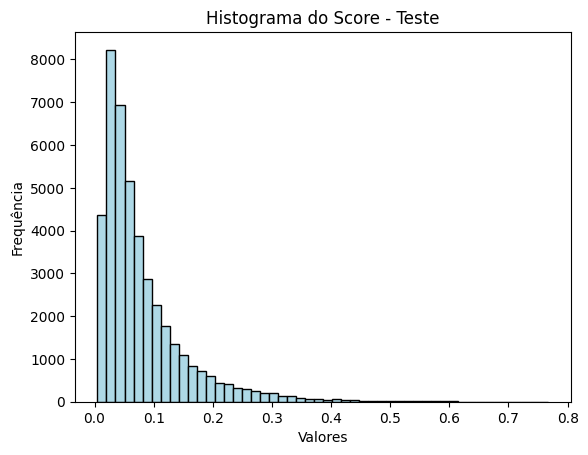

In [ ]:
# Plotando o histograma de teste.
plt.hist(X_test.Score_1, color='lightblue', bins=50, edgecolor='black')
plt.title('Histograma do Score - Teste')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.show()

In [ ]:
# Trazendo o target para a tabela.
abt_train_02 = X_train.merge(y_train, left_index=True, right_index=True, how='inner')
abt_test_02 = X_test.merge(y_test, left_index=True, right_index=True, how='inner')

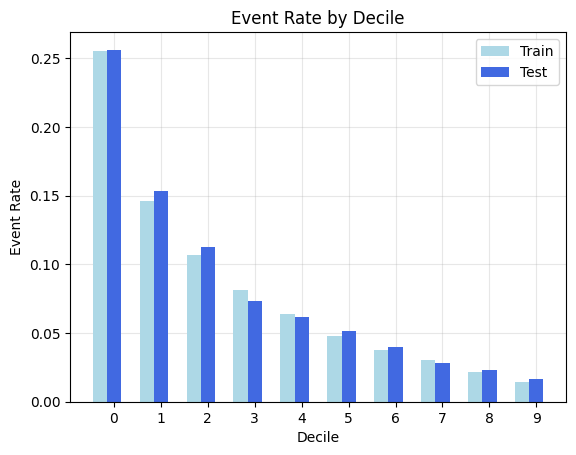

In [ ]:
# Chamando a função das métricas e decis.
metrics, ord_score_train, ord_score_test = calculate_metrics_02(abt_train_02, abt_test_02, 'Score_1', 'Score_0', 'TARGET', bins=10)

In [ ]:
ord_score_train

,decile,min_score,max_score,event_rate,volume
0,0,0.1468,0.8271,0.255734,17221
1,1,0.8272,0.8821,0.146220,17248
2,2,0.8822,0.9111,0.107137,17249
3,3,0.9112,0.9301,0.081590,17208
4,4,0.9302,0.9439,0.063836,17216
5,5,0.9440,0.9549,0.047744,17217
6,6,0.9550,0.9643,0.037892,17233
7,7,0.9644,0.9723,0.030322,17380
8,8,0.9724,0.9802,0.021395,17060
9,9,0.9803,0.9960,0.014441,17173


In [ ]:
ord_score_test

,decile,min_score,max_score,event_rate,volume
0,0,0.2326,0.8272,0.256321,4311
1,1,0.8273,0.8825,0.153471,4307
2,2,0.8826,0.9107,0.112892,4305
3,3,0.9108,0.9302,0.073312,4324
4,4,0.9303,0.9439,0.061671,4297
5,5,0.9440,0.9547,0.051181,4318
6,6,0.9548,0.9640,0.040167,4307
7,7,0.9641,0.9720,0.028466,4321
8,8,0.9721,0.9799,0.023245,4259
9,9,0.9800,0.9951,0.016268,4303


<br>
<br>
<br>
<br>

## **Análise das faixas de score e apetite de risco**

### **Treino**

**Apetite de risco de 8,0% (atual da carteira)**

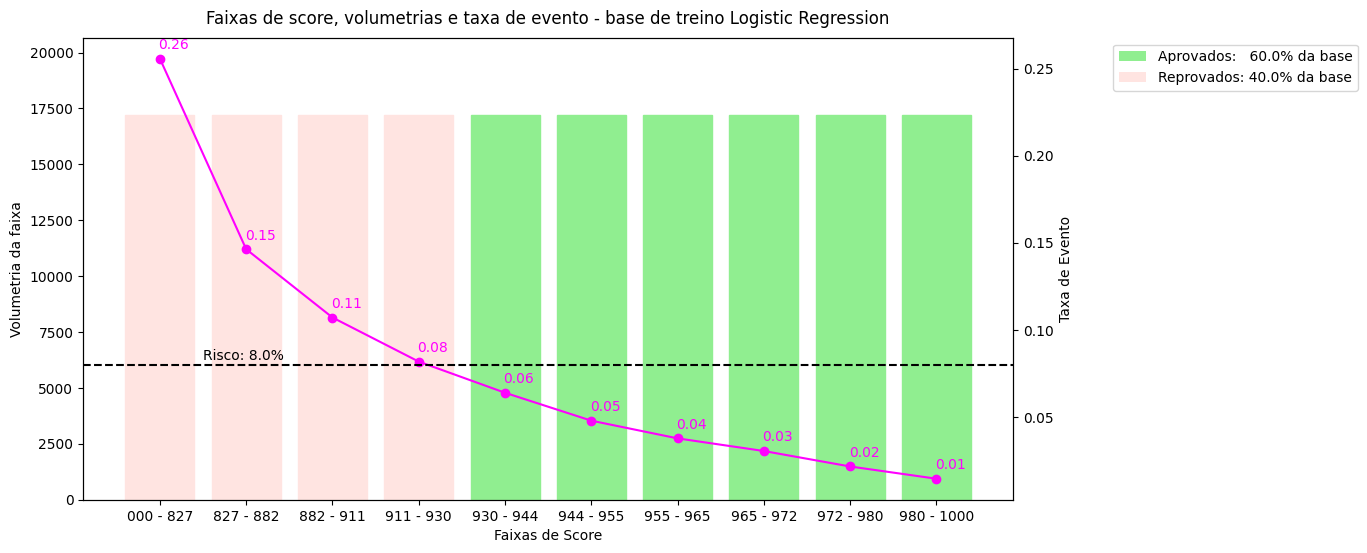

In [ ]:
  # Análise da carteira dos dados de treino - Apetite de risco de 8,0%.
faixas_treino_8 = carteira_treino_rl(model = model, name_model = 'Logistic Regression', risk = 0.08, X_train = X_train, y_train = y_train, prob_train = X_train['Score_0'])

**Apetite de risco de 5,0% (conservador)**

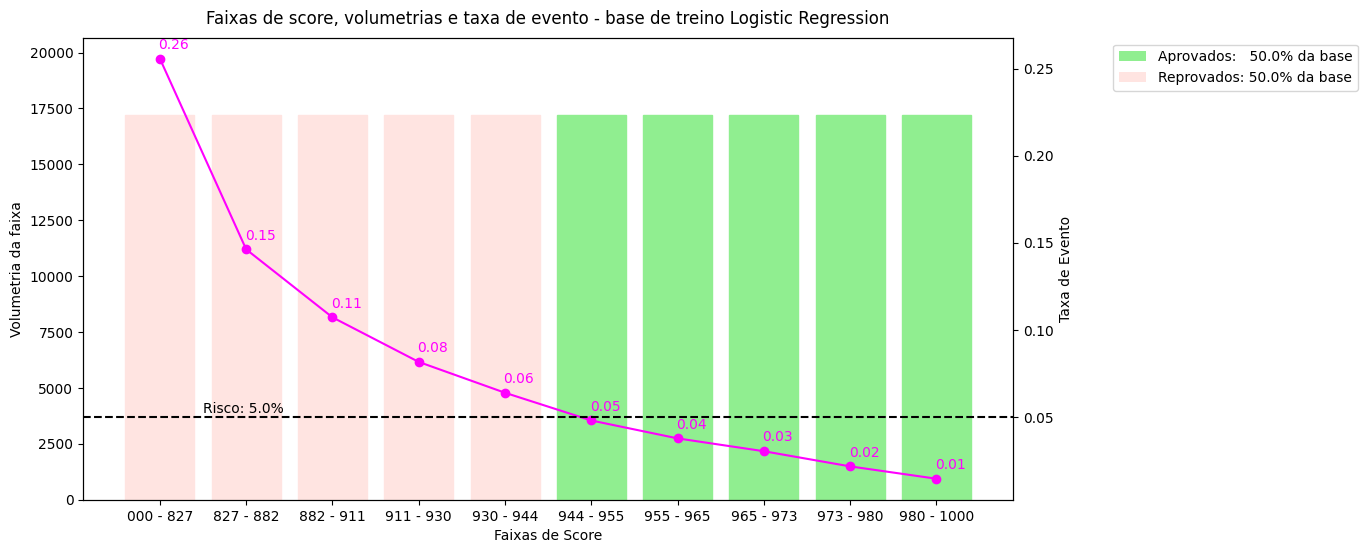

In [ ]:
# Análise da carteira dos dados de treino - Apetite de risco de 5,0%.
faixas_treino_5 = carteira_treino_rl(model = model, name_model = 'Logistic Regression', risk = 0.05, X_train = X_train, y_train = y_train, prob_train = X_train['Score_0'])

**Apetite de risco de 12,0% (ousado)**

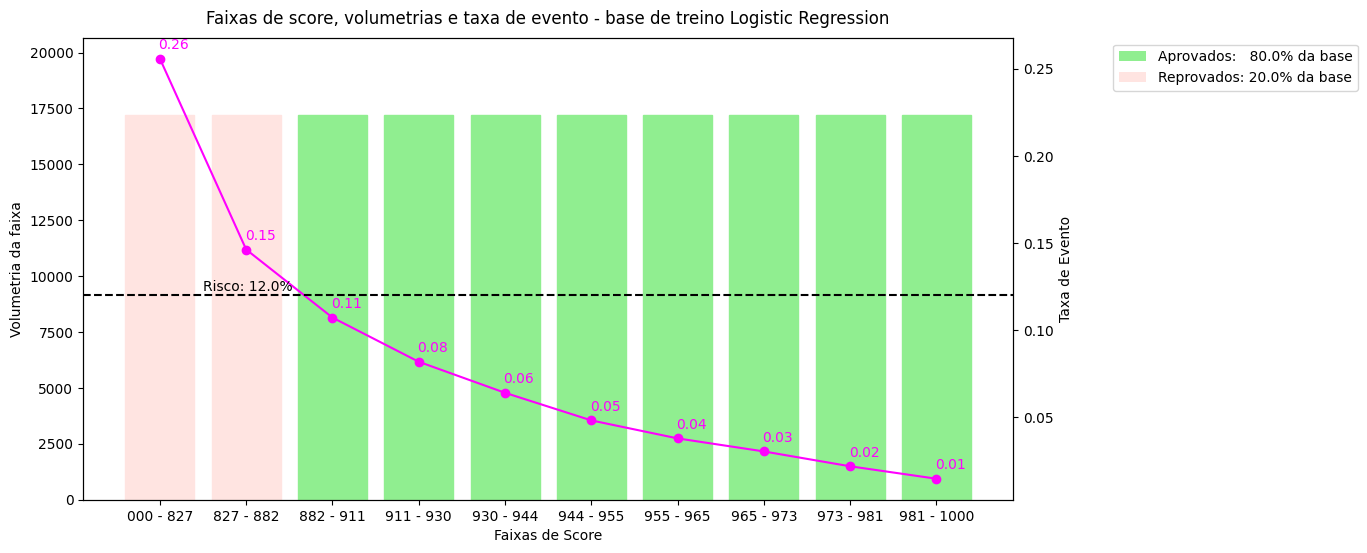

In [ ]:
# Análise da carteira dos dados de treino - Apetite de risco de 12,0%.
faixas_treino_12 = carteira_treino_rl(model = model, name_model = 'Logistic Regression', risk = 0.12, X_train = X_train, y_train = y_train, prob_train = X_train['Score_0'])

<br>

### **Teste**

**Apetite de risco de 8,0% (atual da carteira)**

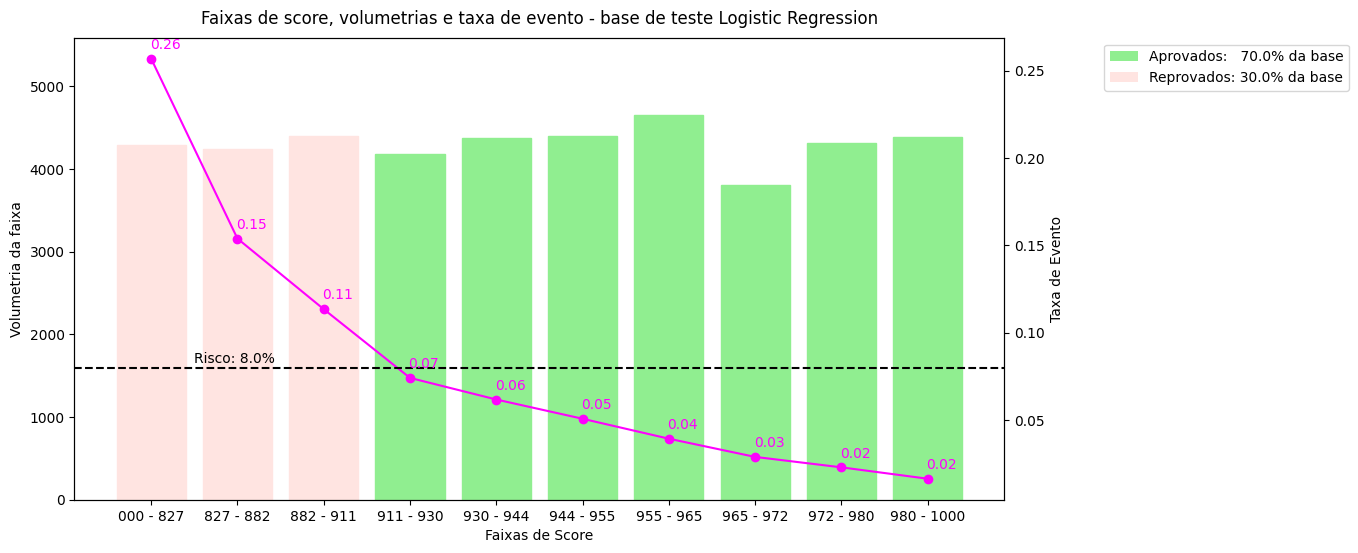

In [ ]:
# Análise da carteira dos dados de teste - Apetite de risco de 8,0%.
faixas_teste_8 = carteira_teste_rl(faixas = faixas_treino_8, model = model, name_model = 'Logistic Regression', risk=0.08, X_test = X_test, y_test = y_test, prob_test = X_test['Score_0'])

**Apetite de risco de 5,0% (conservador)**

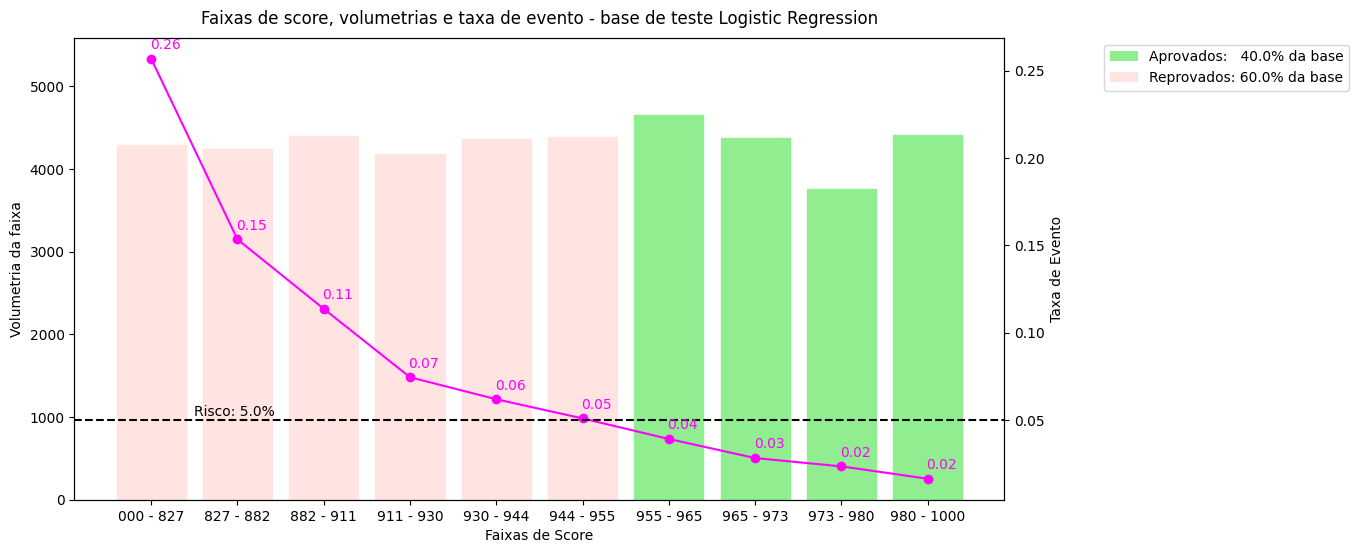

In [ ]:
# Análise da carteira dos dados de teste - Apetite de risco de 8,0%.
faixas_teste_5 = carteira_teste_rl(faixas = faixas_treino_5, model = model, name_model = 'Logistic Regression', risk=0.05, X_test = X_test, y_test = y_test, prob_test = X_test['Score_0'])

**Apetite de risco de 12,0% (ousado)**

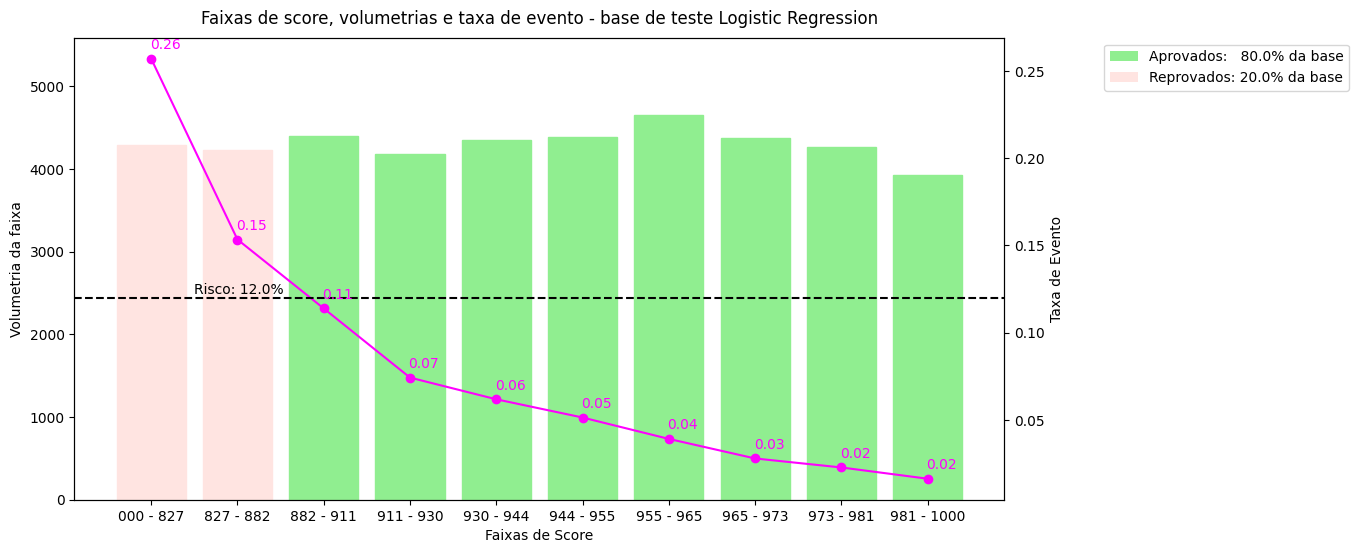

In [ ]:
# Análise da carteira dos dados de teste - Apetite de risco de 12,0%.
faixas_teste_12 = carteira_teste_rl(faixas = faixas_treino_12, model = model, name_model = 'Logistic Regression', risk=0.12, X_test = X_test, y_test = y_test, prob_test = X_test['Score_0'])